# Predicting Interest Rate

The last step of our project is to predict the interest rate for a loan. Just
 like with the sub-grade, we will use the same dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pycaret.regression import *
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split

from script import make_mi_scores, plot_mi_scores

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_pickle('./df.pkl')

Let us choose the 10 features with the highest mutual information score.

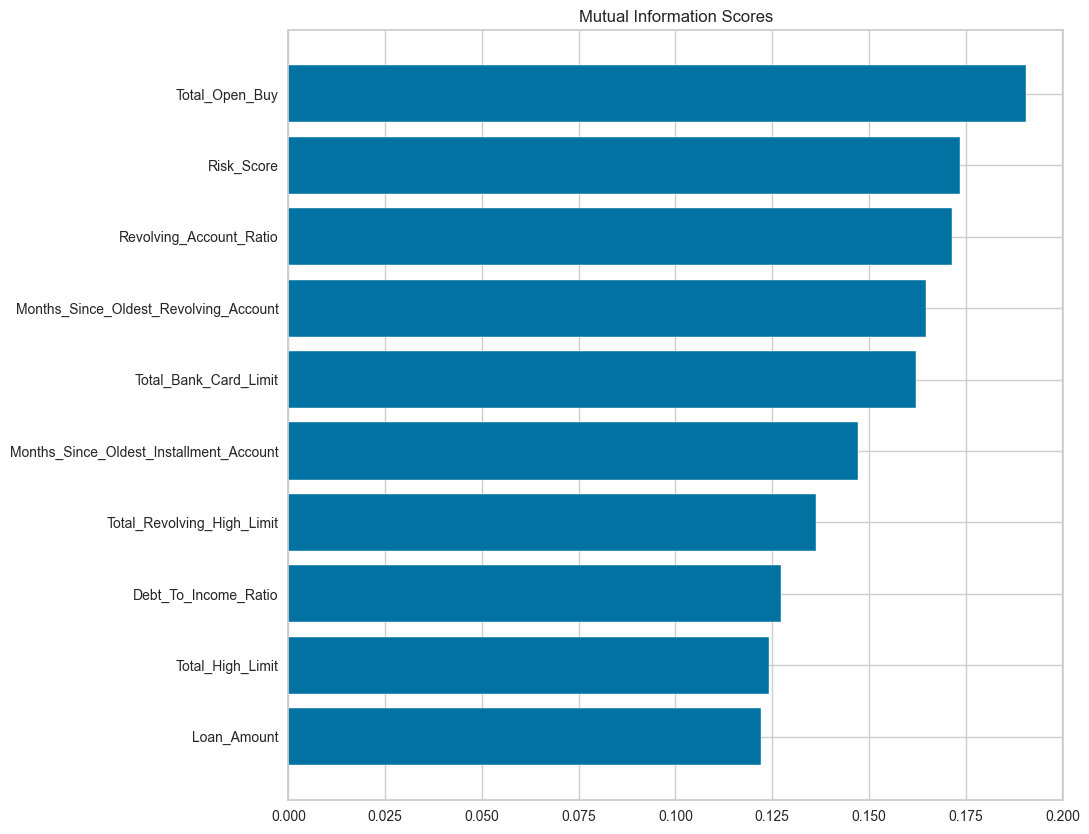

In [3]:
sample = df.sample(frac=0.05, random_state=42).dropna()
mi_scores = make_mi_scores(
    sample.drop(['Interest_Rate', 'id'], axis=1)
    .select_dtypes
    (include=np.number), sample['Interest_Rate'], model='regression')

plt.figure(dpi=100, figsize=(10, 10))
plot_mi_scores(mi_scores.nlargest(10))

## Exploratory Data Analysis

In [35]:
mi_scores.nlargest(10).index

Index(['Total_Open_Buy', 'Risk_Score', 'Revolving_Account_Ratio',
       'Months_Since_Oldest_Revolving_Account', 'Total_Bank_Card_Limit',
       'Months_Since_Oldest_Installment_Account', 'Total_Revolving_High_Limit',
       'Debt_To_Income_Ratio', 'Total_High_Limit', 'Loan_Amount'],
      dtype='object')

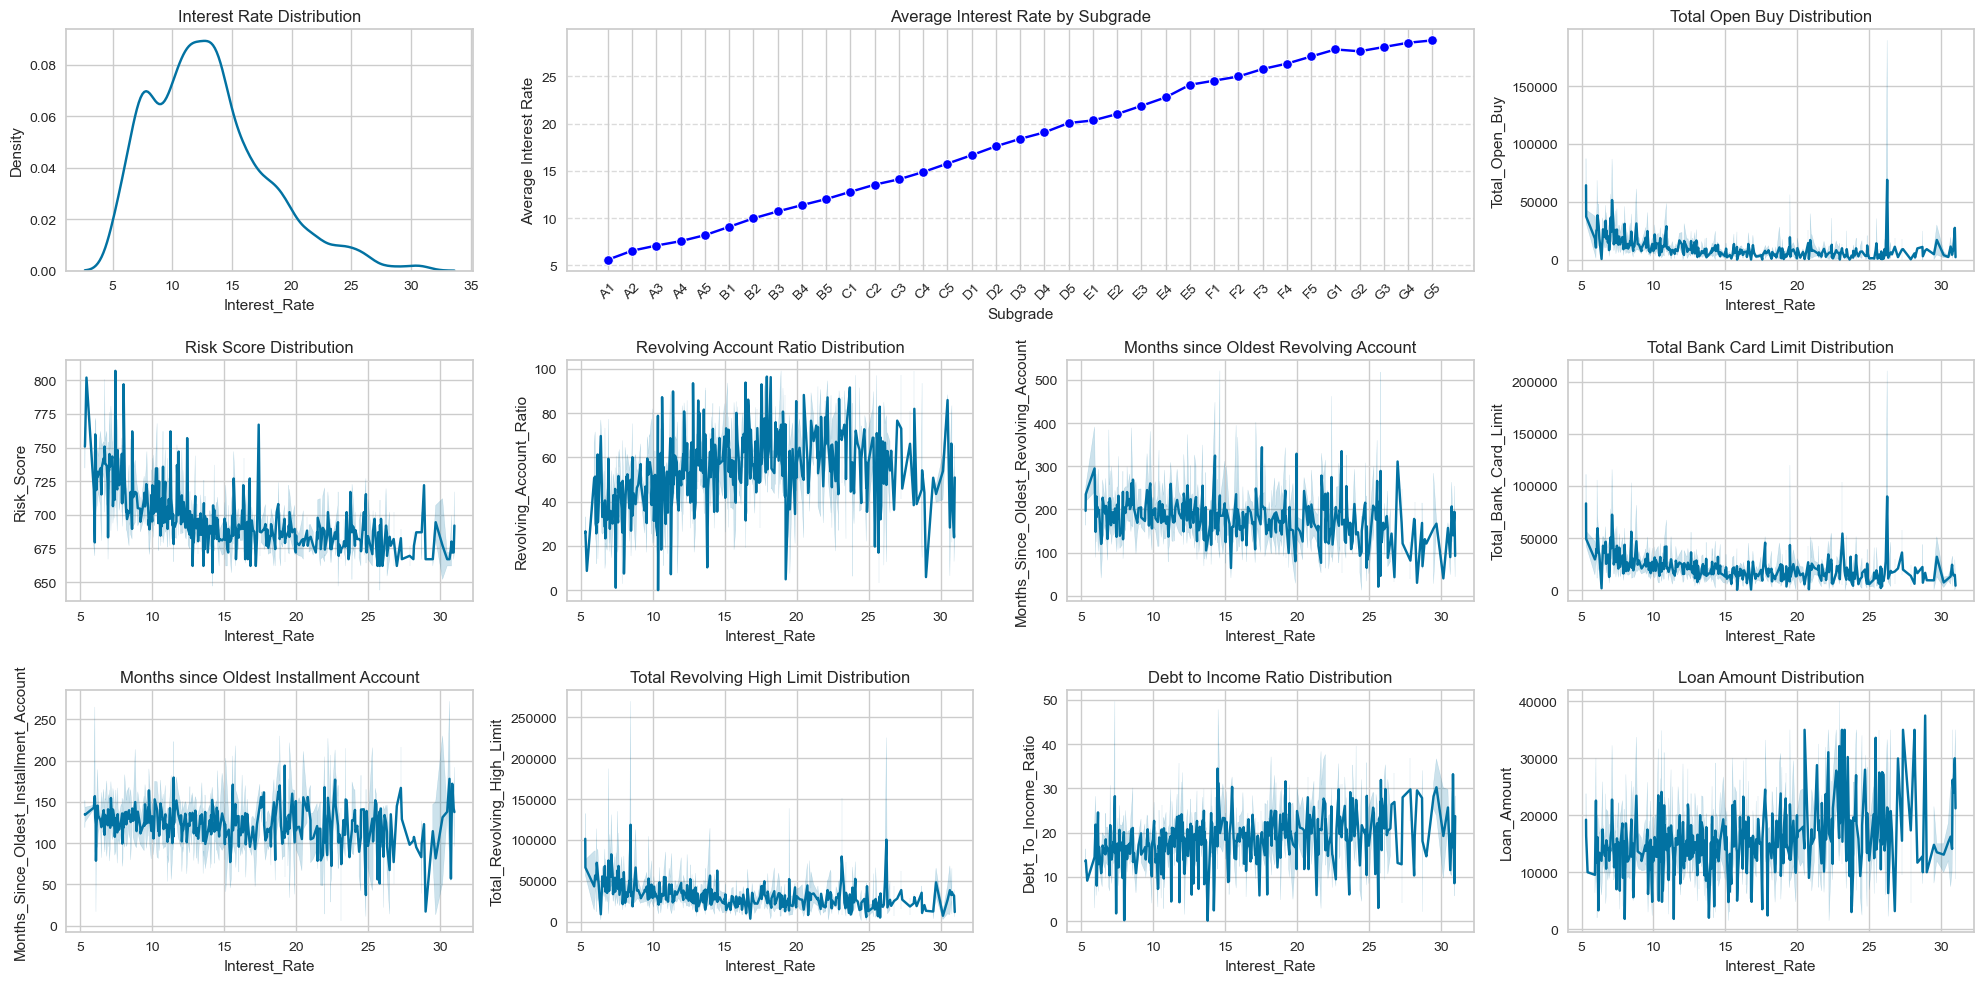

In [5]:
df_sample = df.sample(5000)

average_interest_by_subgrade = df.groupby('Sub_Grade')[
    'Interest_Rate'].mean().reset_index()

plt.figure(figsize=(20, 10))

plt.subplot2grid((3, 4), (0, 0))
sns.kdeplot(data=df_sample, x='Interest_Rate')
plt.title('Interest Rate Distribution')

plt.subplot2grid((3, 4), (0, 1), colspan=2)
sns.lineplot(data=average_interest_by_subgrade, x='Sub_Grade',
             y='Interest_Rate', marker='o', color='blue')
plt.title('Average Interest Rate by Subgrade')
plt.xlabel('Subgrade')
plt.ylabel('Average Interest Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot2grid((3, 4), (0, 3))
sns.lineplot(data=df_sample, y='Total_Open_Buy', x='Interest_Rate')
plt.title('Total Open Buy Distribution')

plt.subplot2grid((3, 4), (1, 0))
sns.lineplot(data=df_sample, y='Risk_Score', x='Interest_Rate')
plt.title('Risk Score Distribution')

plt.subplot2grid((3, 4), (1, 1))
sns.lineplot(data=df_sample, y='Revolving_Account_Ratio',
                x='Interest_Rate')
plt.title('Revolving Account Ratio Distribution')

plt.subplot2grid((3, 4), (1, 2))
sns.lineplot(data=df_sample, y='Months_Since_Oldest_Revolving_Account',
                x='Interest_Rate')
plt.title('Months since Oldest Revolving Account')

plt.subplot2grid((3, 4), (1, 3))
sns.lineplot(data=df_sample, y='Total_Bank_Card_Limit', x='Interest_Rate')
plt.title('Total Bank Card Limit Distribution')

plt.subplot2grid((3, 4), (2, 0))
sns.lineplot(data=df_sample, y='Months_Since_Oldest_Installment_Account',
                x='Interest_Rate')
plt.title('Months since Oldest Installment Account')

plt.subplot2grid((3, 4), (2, 1))
sns.lineplot(data=df_sample, y='Total_Revolving_High_Limit',
                x='Interest_Rate')
plt.title('Total Revolving High Limit Distribution')

plt.subplot2grid((3, 4), (2, 2))
sns.lineplot(data=df_sample, y='Debt_To_Income_Ratio', x='Interest_Rate')
plt.title('Debt to Income Ratio Distribution')
plt.subplot2grid((3, 4), (2, 3))
sns.lineplot(data=df_sample, y='Loan_Amount', x='Interest_Rate')
plt.title('Loan Amount Distribution')

plt.tight_layout()
plt.show()


In this case, there does not seem to be a strong correlation between the
interest rate and any of the other features, except for sub-grade. This will
be corroborated in the statistical analysis section.

## Statistical Analysis

For this section, we are going to perform two tests. First, we are going to us
ANOVA to find out if there is a significant relationship between sub-grade and
 interest rate. Then, Pearson's correlation coefficient will show if there
 are any correlations between the numeric features.

In [53]:
groups = []
for name, group in df.groupby('Sub_Grade'):
    groups.append(group['Interest_Rate'])

f_statistic, p_value = f_oneway(*groups)

print("ANOVA Results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)


ANOVA Results:
F-statistic: 1425929.9329810322
p-value: 0.0


With a p-value of 0, we can affirm there is significant evidence that at
least one sub-grade has a different mean interest rate.

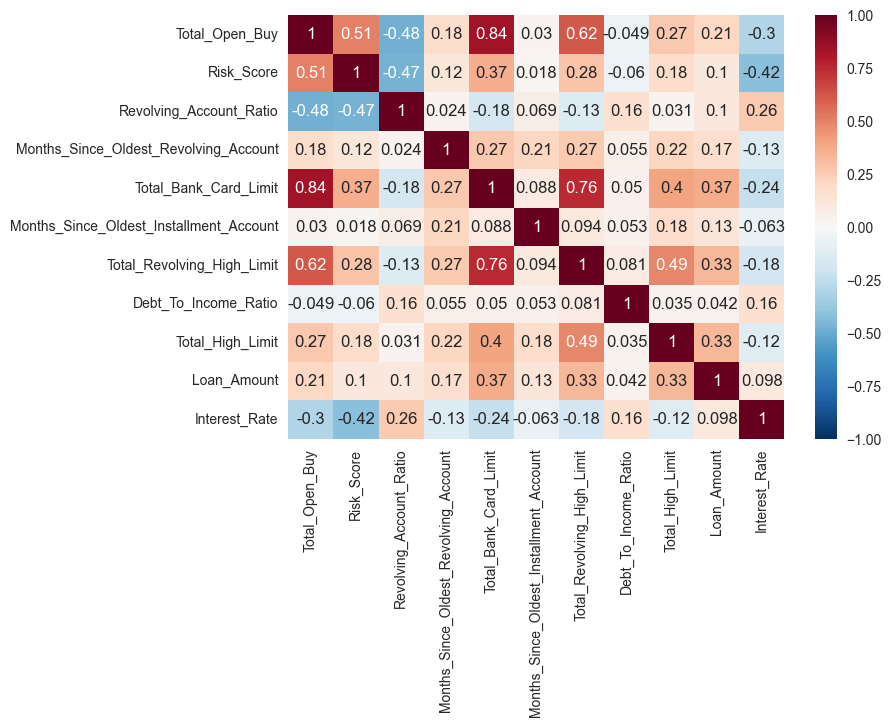

In [54]:
features_highest_mi = mi_scores.nlargest(10).index
df_filtered = df[features_highest_mi]
df_filtered['Interest_Rate'] = df['Interest_Rate']
sns.heatmap(
    df_filtered.corr(numeric_only=True),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)
plt.show()

Indeed, the dependent feature does not seem to be correlated to any of the
other features. We do see some strong correlations between some features, such
as the total bank card limit and the total open buy. An absolute coefficient
higher than 0.5 is considered moderate correlation, while two features with a
 coefficient higher than 0.7 are highly correlated.

## Statistical Modelling

In this case, we are going to build a regression model, trying to maximise
its R2 score.

In [12]:
X = df.drop(['id', 'Interest_Rate'], axis=1)
y = df['Interest_Rate']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    random_state=42)

In [9]:
X_pycaret, X_rest, y_pycaret, y_rest = train_test_split(X_train, y_train,
                                                        train_size=1 / 7,
                                                        random_state=42)

First, we will use a smaller sample to determine model and hyperparameters,
which we will apply to the whole train set.

In [10]:
s = setup(pd.concat([X_pycaret, y_pycaret], axis=1), target='Interest_Rate',
          session_id=123, experiment_name='tune_interest_sample')

,Description,Value
0,Session id,123
1,Target,Interest_Rate
2,Target type,Regression
3,Original data shape,"(226066, 105)"
4,Transformed data shape,"(226066, 131)"
5,Transformed train set shape,"(158246, 131)"
6,Transformed test set shape,"(67820, 131)"
7,Numeric features,98
8,Categorical features,6
9,Rows with missing values,21.9%


In [ ]:
best_interest_model = compare_models(exclude=['svm', 'dummy', 'gbr'], sort='R2')
save_model(best_interest_model, 'model_interest_untuned')
tuned_best_interest_model, tuner = tune_model(best_interest_model,
                                              optimize='R2',
                                              tuner_verbose=3,
                                              return_tuner=True, n_iter=20)
save_model(tuned_best_interest_model, 'model_interest_tuned')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:21:27
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.6893,1.0069,1.0033,0.9569,0.0600,0.0502,3.6860
ridge,Ridge Regression,0.6893,1.0069,1.0033,0.9569,0.0600,0.0502,1.7540
br,Bayesian Ridge,0.6892,1.0069,1.0033,0.9569,0.0600,0.0502,3.1680
lasso,Lasso Regression,0.7259,1.0892,1.0436,0.9533,0.0630,0.0541,13.1300
en,Elastic Net,0.7259,1.0890,1.0435,0.9533,0.0629,0.0541,56.4480
llar,Lasso Least Angle Regression,0.7259,1.0892,1.0436,0.9533,0.0630,0.0541,2.2710
omp,Orthogonal Matching Pursuit,3.2698,17.9170,4.2328,0.2322,0.2992,0.2797,2.2880
huber,Huber Regressor,4.4483,59.0789,7.6756,-1.5311,0.3995,0.3656,10.6540
par,Passive Aggressive Regressor,6.9908,135.2944,10.2397,-4.7885,0.5996,0.6170,4.0840
lar,Least Angle Regression,8364150.6492,1708540491882460.0000,13076961.7555,-72648982264890.7188,2.8478,701076.5919,2.2560


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [5]:
tuned_best_interest_model = load_model('model_interest_tuned')

Transformation Pipeline and Model Successfully Loaded


Now that we have our model and hyperparameters, we are going to build one using
the
entire train set.

In [14]:
s = setup(pd.concat([X_train, y_train], axis=1), target='Interest_Rate',
          session_id=123)

,Description,Value
0,Session id,123
1,Target,Interest_Rate
2,Target type,Regression
3,Original data shape,"(1582467, 105)"
4,Transformed data shape,"(1582467, 131)"
5,Transformed train set shape,"(1107726, 131)"
6,Transformed test set shape,"(474741, 131)"
7,Numeric features,98
8,Categorical features,6
9,Rows with missing values,22.1%


In [14]:
final_model_untuned = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6008,0.7510,0.8666,0.9681,0.0529,0.0444
1,0.5979,0.7340,0.8567,0.9685,0.0520,0.0440
2,0.5965,0.7385,0.8593,0.9684,0.0526,0.0441
3,0.5973,0.7498,0.8659,0.9678,0.0532,0.0442
4,0.5983,0.7319,0.8555,0.9688,0.0521,0.0441
5,0.5999,0.7418,0.8613,0.9681,0.0529,0.0444
6,0.5995,0.7617,0.8728,0.9677,0.0534,0.0443
7,0.6007,0.7499,0.8660,0.9680,0.0530,0.0443
8,0.6002,0.7540,0.8683,0.9677,0.0533,0.0444


In [39]:
final_model_tuned = tune_model(final_model_untuned,
                               custom_grid={'booster': ['gbtree'],
                                            'colsample_bytree': [0.9],
                                            'learning_rate': [0.15],
                                            'max_depth': [7],
                                            'min_child_weight': [3],
                                            'n_estimators': [290],
                                            'reg_alpha': [2],
                                            'reg_lambda': [0.7],
                                            'scale_pos_weight': [37.1]}
                               , optimize='R2', n_iter=1, fold=2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5865,0.7227,0.8501,0.9691,0.0518,0.0433
1,0.5868,0.7300,0.8544,0.9688,0.0523,0.0435
Mean,0.5867,0.7264,0.8523,0.9689,0.0521,0.0434
Std,0.0001,0.0037,0.0021,0.0001,0.0002,0.0001


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Our R2 score is 0.9689, which means 96.89% of variance in the interest rate
variable that can be explained by the independent variables. Since sub-grade
and interest rate are deeply correlated, it is not unusual to get such a high
 score.

In [40]:
evaluate_model(final_model_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

As we can see, there is a diagonal line in the residuals. It seems that for a
 specific interest rate, we are getting results that differ significantly
 from it. Let us take a closer result at our predictions.

In [42]:
pred_train = predict_model(final_model_tuned)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.5844,0.7171,0.8468,0.9693,0.0518,0.0432


In [49]:
worst_predictions = pred_train[
    abs(pred_train['Interest_Rate'] - pred_train['prediction_label']) > 6]
worst_predictions['Interest_Rate'].value_counts()

6.000000     107
28.719999      3
30.490000      2
28.690001      1
30.170000      1
29.990000      1
24.889999      1
29.490000      1
Name: Interest_Rate, dtype: int64

Indeed, it seems they are coming from interest rate 6. Checking the sub-grade
 could let us know what the issue is.

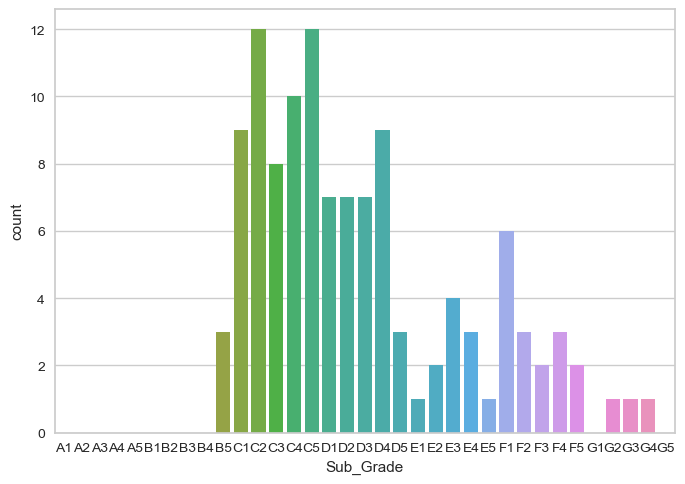

In [67]:
sns.countplot(data=worst_predictions, x='Sub_Grade')
plt.show()

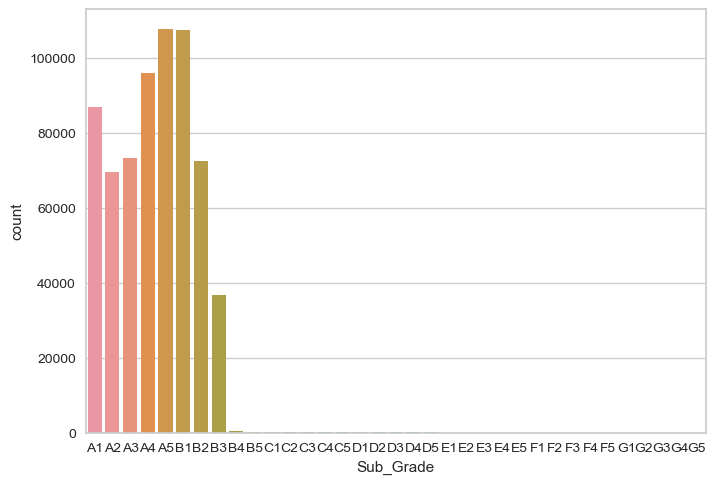

In [70]:
sns.countplot(data=df[df['Interest_Rate'] < 10], x='Sub_Grade')
plt.show()

As we can see, the poorly predicted results have a sub-grade significantly
lower than what would be expected for such an interest rate. Since the
interest rate is exactly the same, 6.0, it is likely to be due to an error
when entering the data. Let's check how our model performs with the test
dataset.

In [71]:
final_interest_model = finalize_model(final_model_tuned)

In [83]:
test_set = pd.concat([X_test, y_test], axis=1)
pred_unseen = predict_model(final_interest_model, test_set)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.5818,0.7046,0.8394,0.9697,0.0516,0.0431


As we can see, we get a similar R2 score. We can now save this model, ready for production.

In [77]:
save_model(final_interest_model, 'final_interest_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Number_Trades_24_Months',
                                              'Annual_Income', 'Total_Open_Buy',
                                              'Number_Delinquent_2_Years',
                                              'Delinquent_Amount',
                                              'Debt_To_Income_Ratio',
                                              'Employment_Length_In_Years',
                                              'Loan_Amount', 'Risk_Score',
                                              'Inquiries_6_Months',
                                              'Mortgage_Accounts', 'Open_Trades',
                                              'Revolving_Acco...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=

## Conclusion

This means we have reached the end of our project. Our goal was to automate
our lending decisions, for which we have divided our target in four goals:
- Determine whether a loan was accepted
For accepted loans:
- Predict its grade
- Once we know its grade, predict its sub-grade
- Once we know its sub-grade, predict its interest rate

For that purpose, we have created four different projects, each named after
each one of the phases of the project, in order to create four models that
can fulfill this task.

After performing EDA and statistical analysis, we have used PyCaret to
automate the model building process by letting it build a pipeline, compare
different models, and tune the best model based on the chosen metric. We
evaluated the final model and tested it with unused data.

Some models were more successful than others. While our first model
classified almost all loans correctly, the grade and sub-grade model
struggled to identify the right class, possibly because of how many
possibilities there are for each model. For our interest model, because
interest is heavily related to grade and sub-grade, we ended up with fairly
accurate predictions.

As it often happens with projects, there are a number of things that could be
 improved, or done differently. First of all, while PyCaret simplified the
 model selection and building process significantly, it also has several
 compatibility issues, which make deployment considerably more difficult than
  other packages. Therefore, it could be wise to explore other options.

As for model building, it would have been advisable to perform feature
selection, and to use a custom metric to predict the sub-grade, since the
goal was to build an ordinal regression model. Metrics and approaches such as
Maximum Mean Average Error, macro-averaged versions of common measures, or chain
maximizing ordinal metric learning have been proposed for this purpose
Unfortunately this idea could not be carried out due to time constraints and
bugs in the PyCaret package that did not allow to use custom metrics as the
value returned for those would always be 0.00.

A project such as this one could be an excellent opportunity to explore
everything Google Cloud has to offer. From storage, to model gardens, to
model explainability. This approach would have probably simplified our task
and built more efficient models, and will be considered by the author in
upcoming projects.